In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
plt.rcParams['figure.figsize'] = (15, 12)
plt.style.use('seaborn')
%matplotlib inline

df = pd.read_csv('breast_cancer.csv').drop(['id', 'Unnamed: 32'], axis=1)

df['diagnosis'] = df['diagnosis'].replace(['B', 'M'], [0, 1])



In [2]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


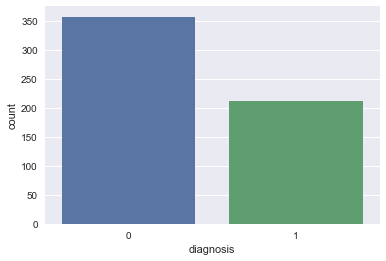

In [3]:
sns.countplot(df['diagnosis']);

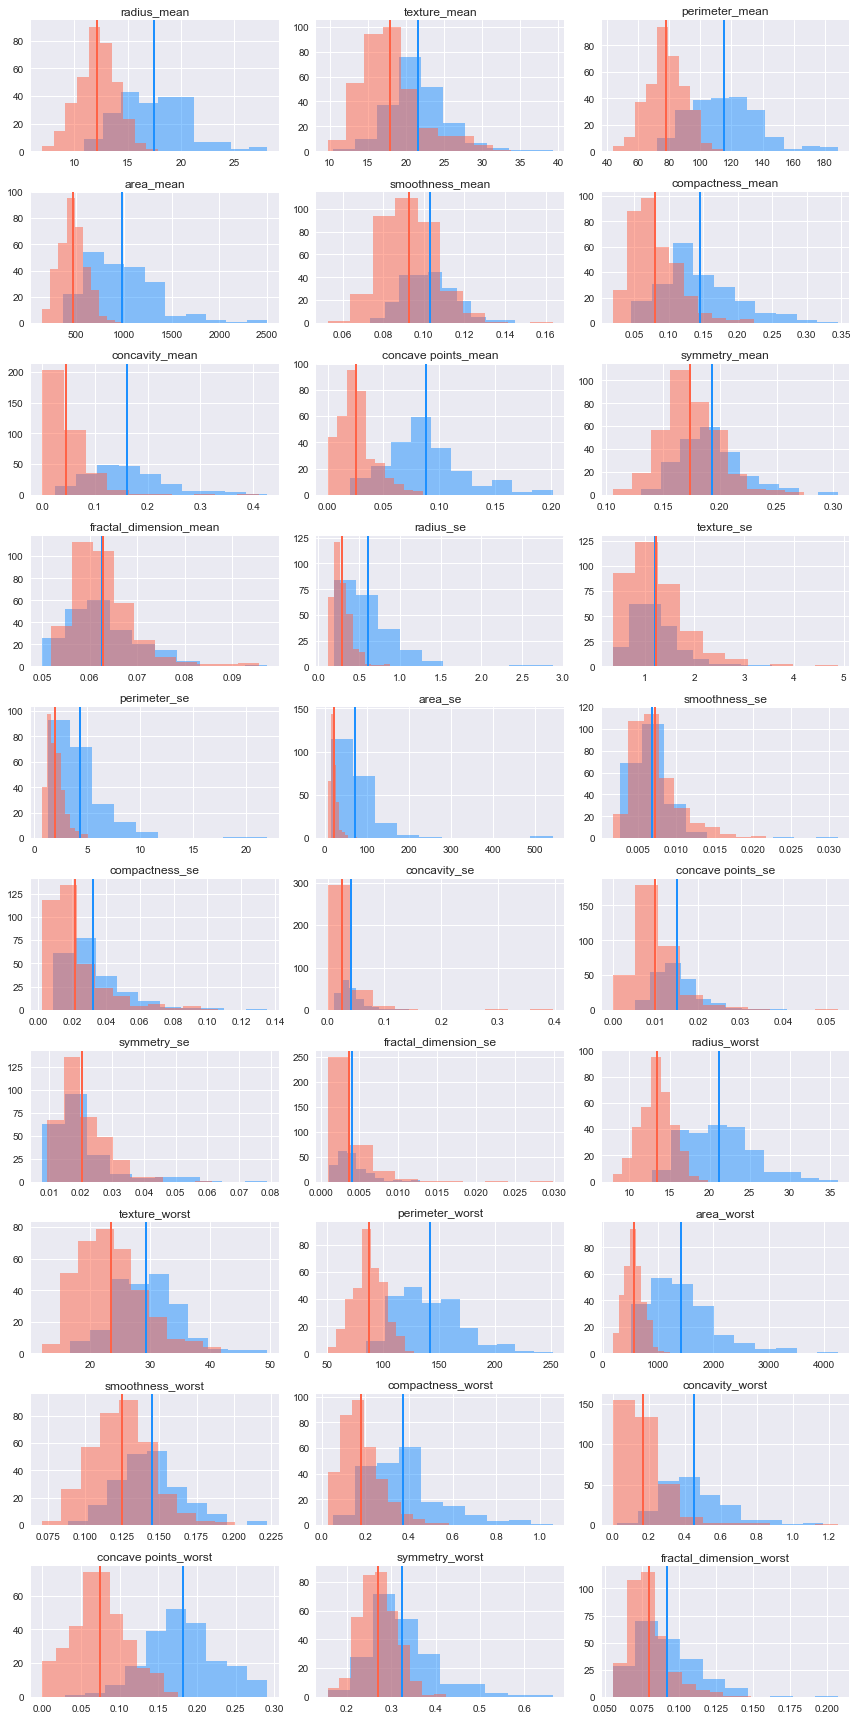

In [4]:
clean_columns = df.columns.drop('diagnosis')
rows = 10
cols = np.ceil(clean_columns.shape[0] / rows)
pal = ['dodgerblue', 'tomato']
plt.figure(figsize=(12, 24))
percentiles = []
preserve_overlap = []
varname = []
for index, colname in enumerate(clean_columns):
    plt.subplot(rows, cols, index + 1)
    for n,i in enumerate(df['diagnosis'].unique()):
        tmp_select = df[df['diagnosis'] == i][colname]
        plt.hist(tmp_select, alpha=.5, color=pal[n])
        plt.axvline(np.mean(tmp_select), lw=2, color=pal[n])
        plt.title(colname)
        varname.append(colname)
        plt.title("{}".format(colname))
plt.tight_layout()

In [111]:
def histogram_overlap(df, attribute, target, perc=100):
    # get lower bound
    empirical_lower_bound = np.floor(df[attribute].min())
    # get upper bound
    empirical_upper_bound = np.ceil(df[attribute].max())
    # preserve histograms
    tmp_hist_holder = dict()
    # for each target class
    for unique_value in np.unique(df[target]):
        # get histogram
        tmp, _ = np.histogram(
        # for a specific attribute
        df[df[target] == unique_value][attribute],
        # define percentage
        bins=perc,
        # limit empirical range for comparison
        range=[empirical_lower_bound, empirical_upper_bound]
        )
    # append to dict
    tmp_hist_holder["h_"+str(unique_value)] = tmp
    get_minima = np.minimum(tmp_hist_holder["h_1"], tmp_hist_holder["h_0"])
    intersection = np.true_divide(np.sum(get_minima),
    np.sum(tmp_hist_holder["h_0"]))
    return intersection

In [113]:
#### V2.0
def histogram_overlap(df, attribute, target, perc=100):
    # get lower bound
    empirical_lower_bound = np.floor(df[attribute].min())
    # get upper bound
    empirical_upper_bound = np.ceil(df[attribute].max())
    # preserve histograms
    tmp_hist_holder = dict()
    # for each target class
    for unique_value in np.unique(df[target]):
        # get histogram
        tmp, _ = np.histogram(
        # for a specific attribute
        df[df[target] == unique_value][attribute],
        # define percentage
        bins=perc,
        # limit empirical range for comparison
        range=[empirical_lower_bound, empirical_upper_bound]
        )
    # append to dict
        tmp_hist_holder["h_"+str(unique_value)] = tmp
    get_minima = np.minimum(tmp_hist_holder["h_1"], tmp_hist_holder["h_0"])
    intersection = np.true_divide(np.sum(get_minima), np.sum(tmp_hist_holder["h_0"]))
    return intersection

In [94]:
def p_overlap(df, col_obj):
    df_1 = df.loc[df[col_obj] ==1]
    df_0 = df.loc[df[col_obj] ==0]
    del df_1[col_obj]
    del df_0[col_obj]
    result_1 = []
    result_0 = []
    for col in df_1.columns:
        h1, _ = np.histogram(df_1[col],bins=100)
        result_1.append(h1)
    for col in df_0.columns:
        h0, _ = np.histogram(df_0[col],bins=100)
        result_0.append(h0)
    inter=[]
    for n,l in zip(result_1,result_0):
        get_minima = np.minimum(n,l)
        intersection = np.true_divide(np.sum(get_minima), np.sum(l))
        inter.append(round(intersection,4)*100)
    df_porc = pd.DataFrame({"att": df_1.columns, "%": inter})
    df_porc_sort = df_porc.sort_values(by='%', ascending=False)
    print(df_porc_sort.shape)
    return df_porc_sort

In [114]:
clean_df = df.dropna()
preserve_overlap, varname = [], []
# para cada atributo en la matriz
for i in clean_columns:
    # añadir al final del código
    preserve_overlap.append(
    # el porcentaje de overlap
   histogram_overlap(df, i,'diagnosis')
    )
    # identificamos variables
    varname.append(i)
# Creamos un dataframe con dos atributos
overlap_df = pd.DataFrame({'varname': varname, 'overlap_coef': list(map(lambda x: round(x, 3),
                            preserve_overlap))})
overlap_df = overlap_df.sort_values(by='overlap_coef', ascending=False)
overlap_df

,varname,overlap_coef
19,fractal_dimension_se,0.594
14,smoothness_se,0.591
9,fractal_dimension_mean,0.588
18,symmetry_se,0.569
11,texture_se,0.549
15,compactness_se,0.524
4,smoothness_mean,0.521
8,symmetry_mean,0.510
17,concave points_se,0.507
29,fractal_dimension_worst,0.493


In [115]:
df.dtypes

diagnosis                    int64
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst

In [118]:
x_train_pre, x_test_pre, y_train, y_test = train_test_split(df.drop('diagnosis', axis = 1),
                                                            df['diagnosis'],
                                                            test_size = .3,
                                                            random_state = 11235813)
scaler = StandardScaler().fit(x_train_pre)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)



In [120]:
params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'gamma': [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(SVC(kernel = 'rbf'), params, cv = 10)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [1e-07, 0.0001, 0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [121]:
grid_search.best_params_

{'C': 10, 'gamma': 0.01}

In [122]:
grid_search.best_score_

0.9773869346733668

In [131]:
print(classification_report(y_test, grid_search.best_estimator_.predict(x_test)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.96      0.98        69

   micro avg       0.98      0.98      0.98       171
   macro avg       0.99      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



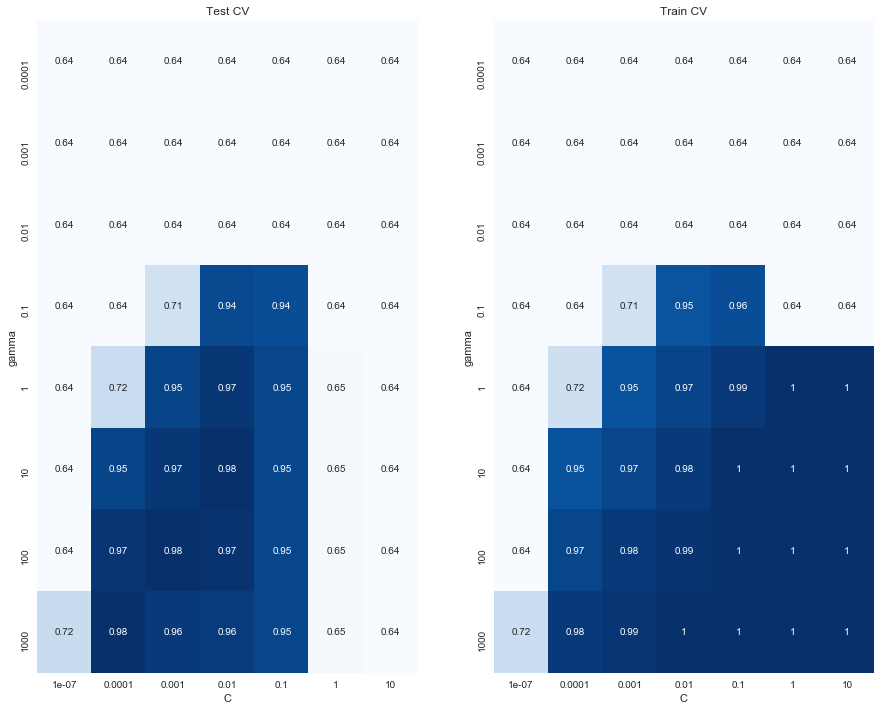

In [140]:

def report_heatmaps(cv_trained):
    param1 = tuple(cv_trained.param_grid.keys())[0]
    param2 = tuple(cv_trained.param_grid.keys())[1]
    fig, _ = plt.subplots(figsize = (15,12))
    plt.subplot(1, 2, 1)
    sns.heatmap(cv_trained.cv_results_['mean_test_score'].reshape(len(cv_trained.param_grid[param1]),
                                                                  len(cv_trained.param_grid[param2])),
                                                                cmap='Blues',
                annot=True,

                xticklabels=cv_trained.param_grid[param2],

                yticklabels=cv_trained.param_grid[param1],cbar=False)
    plt.ylabel(param2)
    plt.xlabel(param1)
    plt.title('Test CV')
    plt.subplot(1, 2, 2)
    sns.heatmap(cv_trained.cv_results_['mean_train_score'].reshape(len(cv_trained.param_grid[param1]),
                                                                   len(cv_trained.param_grid[param2])),
                cmap='Blues',
                annot=True,
                xticklabels=cv_trained.param_grid[param2],
                yticklabels=cv_trained.param_grid[param1],cbar=False)
    plt.ylabel(param2)
    plt.xlabel(param1)
    plt.title('Train CV')
report_heatmaps(grid_search)

In [145]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('grid', GridSearchCV(SVC(kernel = 'rbf'), params, cv = 10))
])
pipe.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('grid', GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max...   pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0))])

In [151]:
print(classification_report(y_test, pipe.predict(x_test)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.96      0.98        69

   micro avg       0.98      0.98      0.98       171
   macro avg       0.99      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

